# Relax Inc. Data Science Challenge

### Summary of findings

The most important factor in predicting adoption is whether the user has opted in to marketing materials, such as marketing drip or the mailing list.  Opting in increases chances of adoption.  Another factor that influences adoption is the month of the year the account is created.  Users who create an account in the second half of the year appear to be adopted at greater rates than those who created one in the first half.  As we only have data from two years, this could be due to the roll-out of a new feature mid-2013 that encouraged adoption—possibly incentives for signing up for marketing materials.

These features (opting in to the mailing list, enabling marketing drip, month of account creation) were identified as important by training both logistic regression and linear SVM models on a training set of the data.  Accuracy for these models on a hold-out test set were 83% and 82%, respectively, and comparison of the mean squared error for both the training and test sets show that the models are not overfit.  The size of their coefficients was evaluated to determine important variables.  These three features had large coefficients in both models.

A Random Forest classifier was also trained on the data with decent accuracy (81%) on the training set but was overfit as is typical with Random Forest models.  An analysis of the feature importances for this model showed that the user ID who invited them to join and the organization to which they belong were the most significant.  A graph of the percent of users in each organization who are adopted found significant differences amongst the organizations.  However, as this model was overfit, these features were not included in the final list of the most important but are worth further investigating.  It's possible user ID of those who invited them and the organization ID features are related as perhaps another member of the organization invited them to the system.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Read in csv files as panda dataframes
users = pd.read_csv('relax_challenge/takehome_users.csv', encoding = 'latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [2]:
engagement = pd.read_csv('relax_challenge/takehome_user_engagement.csv', encoding = 'latin-1')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

In [3]:
#Check data types
engagement.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [4]:
type(engagement.time_stamp[0])

str

In [5]:
#Change time/date column to timestamps
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)
type(engagement.time_stamp[0])

pandas.tslib.Timestamp

In [6]:
#Group by user_id
grouped_engagement = engagement.groupby(['user_id', 'time_stamp'])['user_id'].count().to_frame()
grouped_engagement.columns = ['count']
grouped_engagement.head()

count
user_id time_stamp                
1       2014-04-22 03:53:30      1
2       2013-11-15 03:45:04      1
        2013-11-29 03:45:04      1
        2013-12-09 03:45:04      1
        2013-12-25 03:45:04      1

In [7]:
grouped_engagement = grouped_engagement.reset_index()
grouped_engagement.head()

,user_id,time_stamp,count
0,1,2014-04-22 03:53:30,1
1,2,2013-11-15 03:45:04,1
2,2,2013-11-29 03:45:04,1
3,2,2013-12-09 03:45:04,1
4,2,2013-12-25 03:45:04,1


In [8]:
from datetime import timedelta

def find_adopted_user(dataframe):
    """
    Determines if any users in a dataframe have been active 3 or more instances in a 7-day period.
    Returns a list of True or False to whether user is adopted that correlates to user_id column.
    """
    
    #initialize list of adopted users to be returned
    adopted_user = []
    
    #Run through all user id's
    for i in range(1, max(dataframe.user_id) + 1):
        
        #Find activity by user
        user_activity = dataframe[dataframe.user_id == i]
        if len(user_activity) > 2:
            
            #Sort from oldest to most recent activity
            user_time_stamps = user_activity.time_stamp.sort_values()
            
            #Find if user has 3 instances of activity in 7-day span
            adopted_user.append(find_activity(user_time_stamps, timedelta(days = 7)))
        elif len(user_activity) == 0:
            pass
        else:
            adopted_user.append(False)
    return pd.DataFrame(data = {'object_id': dataframe.user_id.unique(), 
                                'adopted': adopted_user})


def find_activity(series, time_period):
    """
    Determines if there are 3 instances of activity in a 7-day period.
    Returns "adopted" if true.
    """
    
    for i in range(0, len(series) - 2):
        if series.iloc[i + 2] - series.iloc[i] == time_period:
            return True
    return False

adopted = find_adopted_user(grouped_engagement)
adopted.head()                

,adopted,object_id
0,False,1
1,True,2
2,False,3
3,False,4
4,False,5


In [9]:
df = users.merge(adopted, on = 'object_id')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [10]:
df.dtypes

object_id                       int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
adopted                          bool
dtype: object

In [11]:
df.creation_time = pd.to_datetime(df.creation_time)

C:\Users\mdris\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\mdris\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mdris\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

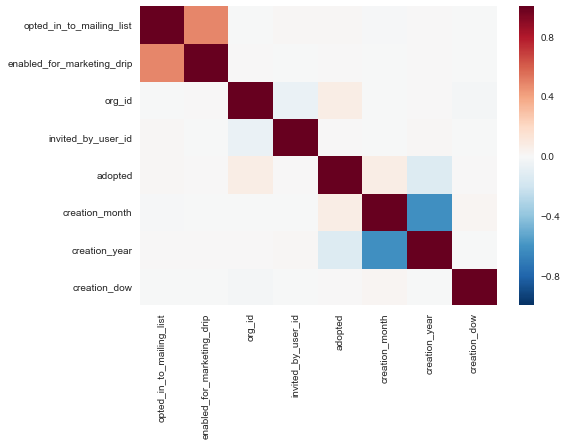

In [12]:
#Narrow dataframe down to features that could affect outcome
df_features = df[['opted_in_to_mailing_list', 'creation_source', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted']]
df_features['creation_month'] = df.creation_time.dt.month
df_features['creation_year'] = df.creation_time.dt.year
df_features['creation_dow'] = df.creation_time.dt.dayofweek

#Look at correlation between features
import seaborn as sns
sns.set_style(style = 'white')

sns.heatmap(df_features.corr());

In [13]:
df_features.groupby(['creation_year', 'creation_month'])['creation_month'].count()

creation_year  creation_month
2012           5                  13
               6                 287
               7                 282
               8                 269
               9                 280
               10                305
               11                292
               12                302
2013           1                 315
               2                 301
               3                 345
               4                 325
               5                 332
               6                 318
               7                 318
               8                 375
               9                 376
               10                396
               11                385
               12                382
2014           1                 441
               2                 411
               3                 530
               4                 542
               5                 701
Name: creation_month, dtype: int64

In [14]:
df_features.head()

,opted_in_to_mailing_list,creation_source,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_month,creation_year,creation_dow
0,1,GUEST_INVITE,0,11,10803.0,False,4,2014,1
1,0,ORG_INVITE,0,1,316.0,True,11,2013,4
2,0,ORG_INVITE,0,94,1525.0,False,3,2013,1
3,0,GUEST_INVITE,0,1,5151.0,False,5,2013,1
4,0,GUEST_INVITE,0,193,5240.0,False,1,2013,3


There appears to be moderate correlation between enabled_for_marketing_drop and opted_in_to_mailing_list, which makes sense as both involve receiving additional marketing materials and would appeal to the same people.  However, the correlation is not so strong as to eliminate one or the other.

The negative correlation between creation month and creation year is possibly due to the fact that only parts of 2014 and 2012 are included in the dataset so we will remove creation year.

In [15]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import label_binarize

#Remove predicted values into separate series.  Binarize other columns with strings.
df_features = df_features.dropna()
y = df_features.adopted
x_data = df_features.drop(['adopted','creation_year'], axis = 1)
x_data.creation_source = label_binarize(x_data.creation_source, classes=[0, 1, 2, 3, 4])


# Split the data into a training and test set.
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y,
                                                    random_state = 10)

#Trying logistic regression
clf = LogisticRegression(random_state = 10)
# Fit the model on the training data.
clf.fit(x_train, y_train)
# Print the accuracy from the testing data.
print('Logit Regression Accuracy: {:.2f}'.format(accuracy_score(clf.predict(x_test), y_test)))

Logit Regression Accuracy: 0.83


In [16]:
print('MSE for training response data: {:.2f}'.format(np.mean((clf.predict(x_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((clf.predict(x_test) - y_test) ** 2)))

MSE for training response data: 0.16
MSE for test response data: 0.17


C:\Users\mdris\Anaconda3\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '-' operator is not supported by numexpr for the bool dtype, use '^' instead
  unsupported[op_str]))


Accuracy is decent and model is not overfit.

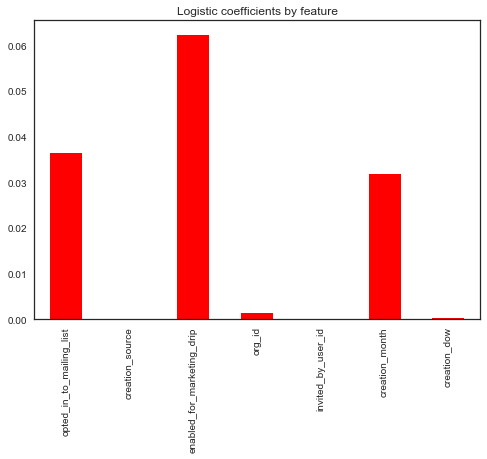

In [17]:
pd.Series(np.abs(clf.coef_[0,:]), index = x_data.columns).plot(kind = 'bar', color = 'r')
plt.title('Logistic coefficients by feature');

Here we can see that whether or not a user opted in to the marketing materials (marketing drip or the mailing list) had the biggest impact on adoption.  Surprisingly creation month also has an impact.

In [18]:
mailing_list = df.groupby(['opted_in_to_mailing_list', 'adopted'])['adopted'].count().to_frame(name = 'count').reset_index()
tot_in = mailing_list[mailing_list.opted_in_to_mailing_list == 1]['count'].sum()
adopted = mailing_list[mailing_list.adopted == True]['count'].sum()

print('Percent of those opted in that are adopted: {:.2f}'.format(adopted * 100 / tot_in))

Percent of those opted in that are adopted: 61.01


Most of those that opt in are adopted.

In [19]:
month = df_features.groupby(['creation_month', 'adopted'])['adopted'].count().to_frame(name = 'total').reset_index()
month

,creation_month,adopted,total
0,1,False,347
1,1,True,67
2,2,False,354
3,2,True,60
4,3,False,412
5,3,True,66
6,4,False,395
7,4,True,47
8,5,False,542
9,5,True,34


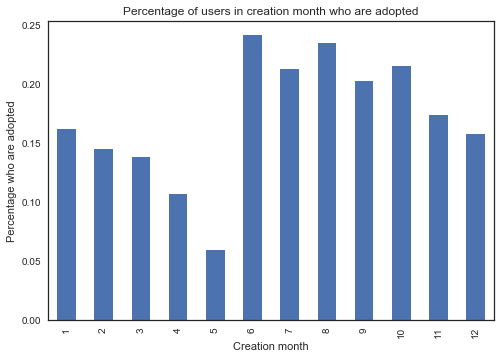

In [42]:
pct = []
for i in range(1, 13):
    pct.append(int(month[(month.creation_month == i) & (month.adopted == True)].total) / month[month.creation_month == i].total.sum())

pd.Series(pct, index = month.creation_month.unique()).plot(kind = 'bar');
plt.title('Percentage of users in creation month who are adopted');
plt.xlabel('Creation month');
plt.ylabel('Percentage who are adopted');

It appears that more users who signed up in the later months of the year became adopted although the difference is not very striking.

In [21]:
#Trying random forest regression
rf_clf = RandomForestClassifier(random_state = 10)
# Fit the model on the training data.
rf_clf.fit(x_train, y_train)
# Print the accuracy from the testing data.
print('RF Regression Accuracy: {:.2f}'.format(accuracy_score(rf_clf.predict(x_test), y_test)))

RF Regression Accuracy: 0.81


In [22]:
print('MSE for training response data: {:.2f}'.format(np.mean((rf_clf.predict(x_train) - y_train) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((rf_clf.predict(x_test) - y_test) ** 2)))

MSE for training response data: 0.02
MSE for test response data: 0.19


C:\Users\mdris\Anaconda3\lib\site-packages\pandas\computation\expressions.py:182: UserWarning: evaluating in Python space because the '-' operator is not supported by numexpr for the bool dtype, use '^' instead
  unsupported[op_str]))


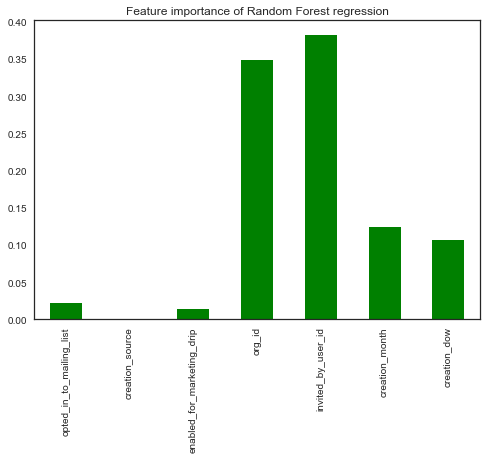

In [23]:
pd.Series(rf_clf.feature_importances_, index = x_data.columns).plot(kind = 'bar', color = 'g')
plt.title('Feature importance of Random Forest regression');

In [50]:
org = df.groupby(['org_id', 'adopted'])['adopted'].count().to_frame(name = 'total').reset_index()
org.head()

,org_id,adopted,total
0,0,False,220
1,0,True,8
2,1,False,157
3,1,True,15
4,2,False,138


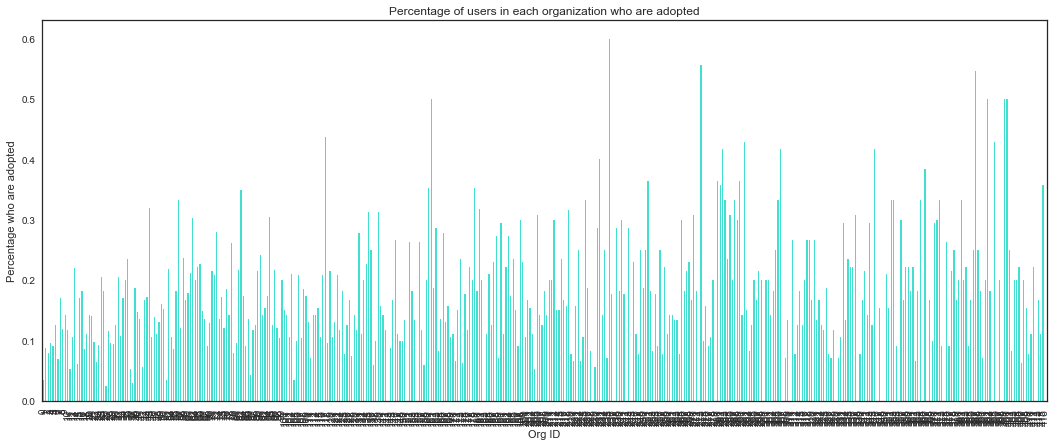

In [112]:
pct = []
for i in org.org_id.unique():
    sub = org[(org.org_id == i) & (org.adopted == True)]
    try:
        pct.append(sub.iloc[0,2] / org[org.org_id == i].total.sum())
    except:
        pct.append(0)

fig = plt.figure(figsize = (18, 7))
pd.Series(pct, index = org.org_id.unique()).plot(kind = 'bar', color = 'turquoise')
plt.title('Percentage of users in each organization who are adopted');
plt.xlabel('Org ID');
plt.ylabel('Percentage who are adopted');

In [151]:
#Trying SVM
svc_clf = SVC(kernel = 'linear', random_state = 10)
# Fit the model on the training data.
svc_clf.fit(x_train, y_train)
# Print the accuracy from the testing data.
print('SVM Accuracy: {:.2f}'.format(accuracy_score(svc_clf.predict(x_test), y_test)))

SVM Accuracy: 0.82


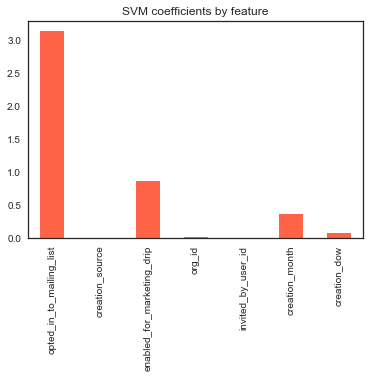

In [154]:
pd.Series(np.abs(svc_clf.coef_[0,:]), index = x_data.columns).plot(kind = 'bar', color = 'tomato')
plt.title('SVM coefficients by feature');